# Intermediate Machine Learning: Assignment 2

**Deadline**

Assignment 2 is due Wednesday, March 9 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:

Go to "File" at the top-left of your Jupyter Notebook
Under "Download as", select "HTML (.html)"
After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
From the print window, select the option to save as a .pdf

**Topics**

 * Convolutional neural networks
 * Gaussian processes
 * Dirichlet processes

This assignment will also help to solidify your Python and Jupyter notebook skills.


## Problem 1: Filter through (15 points)

In this problem, we will ["open the black box"](https://news.yale.edu/2018/12/10/why-take-ydata-because-data-science-shouldnt-be-black-box) and inspect the filters and feature maps learned by a convolutional neural network trained to classify handwritten digits, using the MNIST database.

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### 1.1 Visualizing the filters

To begin, we load the dataset with 60000 training images and 10000 test images.

In [2]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train_binary = keras.utils.to_categorical(y_train, num_classes)
y_test_binary = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Next, we initialize our convolutional neural network similar to the network we used for Assignment 1 Problem 4 except that we now have a few more layers.

In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", name='conv1'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________

In [24]:
batch_size = 128
epochs = 1

init = tf.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train_binary, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
54000/54000 [==============================] - 7s 126us/sample - loss: 0.1220 - acc: 0.9635 - val_loss: 0.0502 - val_acc: 0.9872


In [25]:
score = model.evaluate(x_test, y_test_binary, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.05162191509041004
Test accuracy: 0.98340005


Now that we've trained and tested the model, let's look at the filters learned in the first convolutional layer.

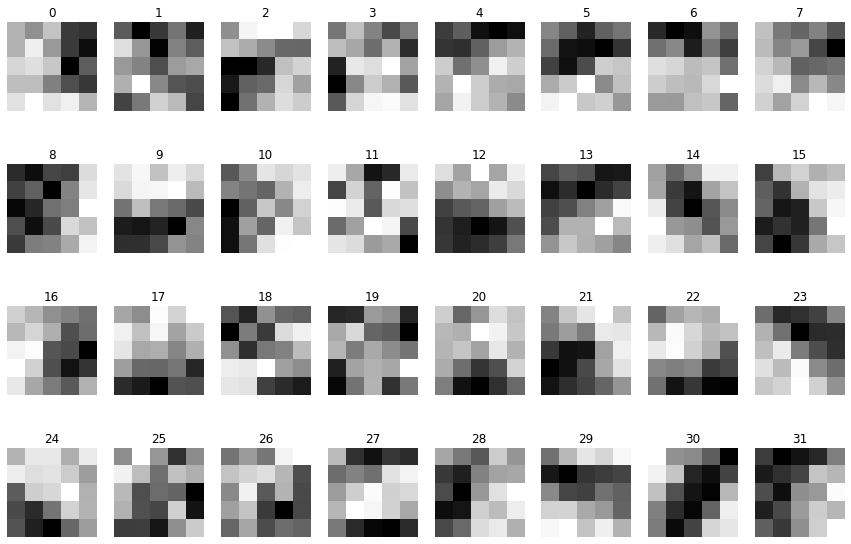

In [26]:
filters_conv1 = model.get_layer(name='conv1').get_weights()[0]

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

for i in range(4):
    for j in range(8):
        f = filters_conv1[:, :, 0, 8*i+j]
        axs[i, j].imshow(f[:, :], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(8*i+j)

Describe what you see. Do (some of) the learned filters make sense to you?

Hint: Many filters have been designed and widely applied in image processing. [Here](http://www.theobjects.com/dragonfly/dfhelp/3-5/Content/05_Image%20Processing/Edge%20Detection%20Filters.htm) are some examples of edge detection filters and their effect on the image. You can find the details about each filter by clicking the links at the bottom.

In [ ]:
# Your Markdown Here

The filters make sense as many of them seem to be a edge detection filter. For instance, filters 9, 17, and 22 seem to detect horizontal edges and filter 28 for vertical edges, which shares a similar role to the Scharr and Prewitt filter. 

### 1.2 Visualizing the feature maps

We can also look at the corresponding feature map for each filter. There are 32 kernels at the first convolutional layer, so there are 32 feature maps for each sample. feature_map_conv1 is a 4D matrix where the first dimension is the index of the sample and the last dimension is the index of the correpsonding filter.

In [27]:
conv1_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('conv1').output)
feature_map_conv1 = conv1_layer_model(x_test)

Randomly draw 16 samples for visualization.

In [28]:
sample_index = random.sample(range(1, len(x_test)), 16)

Choose two filters among all 32 filters from 3.1, visualize their feature maps. There is no need to modify the code, just run the four cells below.

In [43]:
filter_n1 = 17#
filter_n2 = 30#

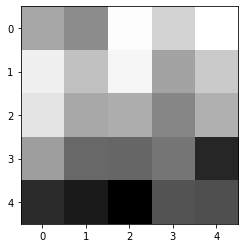

In [44]:
plt.imshow(filters_conv1[:, :, 0, filter_n1], cmap='gray')

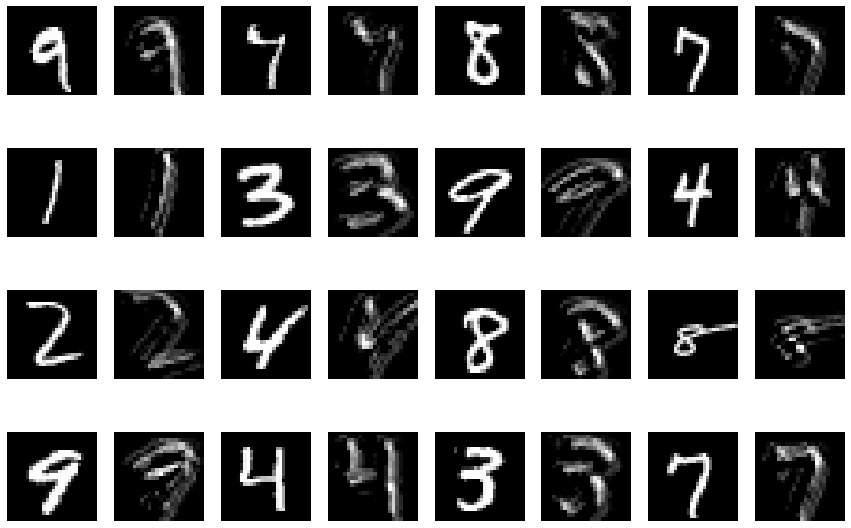

In [45]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv1[sample_index[4*i+j], :, :, filter_n1].eval(session=sess), cmap='gray')
        axs[i, 2*j+1].axis('off')

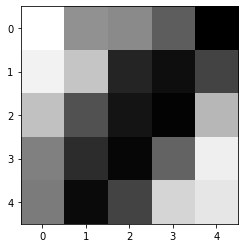

In [46]:
plt.imshow(filters_conv1[:, :, 0, filter_n2], cmap='gray')

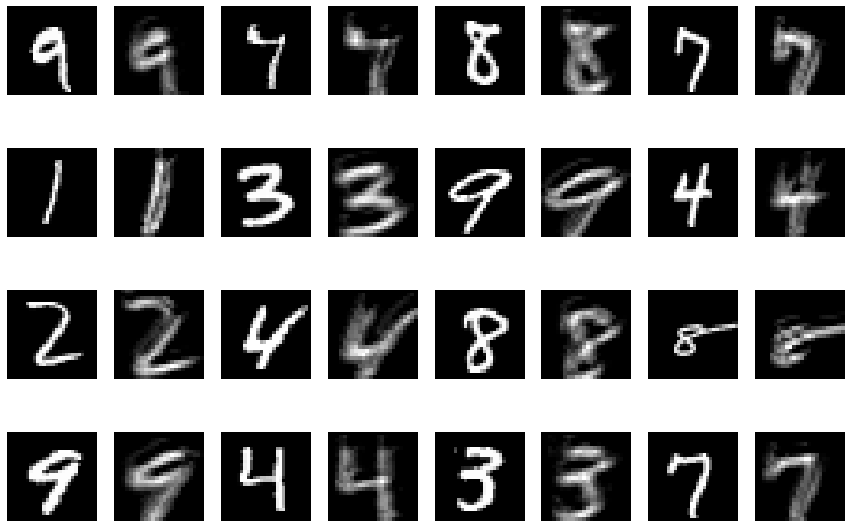

In [47]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv1[sample_index[4*i+j], :, :, filter_n2].eval(session=sess), cmap='gray')
        axs[i, 2*j+1].axis('off')

Comment on what you see in the feature maps.
* How do they correspond to the original images?
* How do they correspond to the filters?
* Why might the feature maps be helpful for classifying digits?

### Answer:
1. Both feature maps of filters 17 and 30 correspond to the original images. We are still able to tell the digits based on the feature maps.
2. For the first filter (#17), the feature maps seem to be the results of horizontal edge detection. For instance, the feature of number 9 in the second row has more emphasis on its horizontal axis. The second filter (#30) seems to detect edges in the oblique direction.
3. The feature maps are helpful to classify digits as their combination represent unique characteristics of distinct digits. For instance, the feature map of digit 1 might be more sensible than other digits when filtered by a vertical edge detector.

### 1.3 Fitting a logistic regression model on feature maps

The features of the images are further summarized after the second convolutional layer.

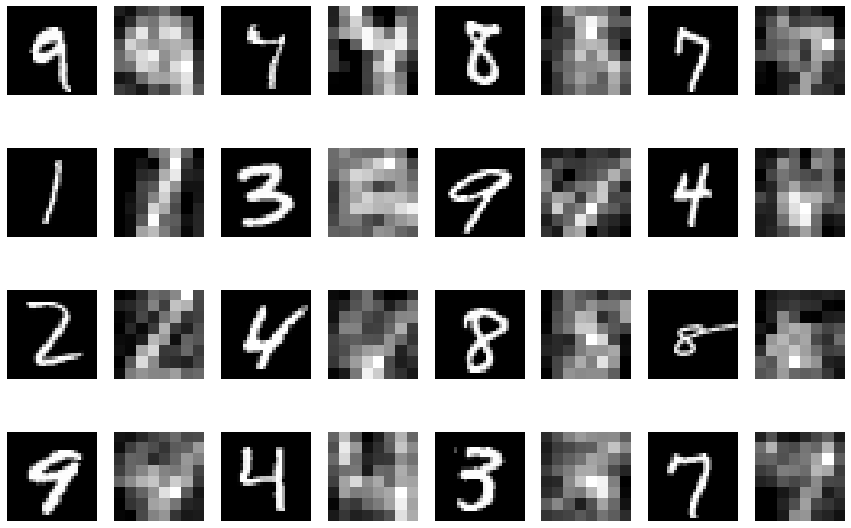

In [49]:
conv2_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('conv2').output)
feature_map_conv2 = conv2_layer_model(x_test)

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv2[sample_index[4*i+j], :, :, 0].eval(session=sess), cmap='gray')
        axs[i, 2*j+1].axis('off')

Build and test a logistic regression model to classify two digits of your choice using the features maps at the second convolutional layer as the input. You may use logistic regression functions such as [LogisticRegression in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use 80% of the data for training and 20% for test.

* How many features are there in your input X? Show the derivation of this number based on the architecture of the convolutional neural network.

* How is your logistic regression model related to the fully connected layer and softmax layer in the convolutional neural network?

* What is the accuracy of your model? Is this expected, or surprising? 

* Comment on any other aspects of your findings that are interesting to you.


## Answer:
1. I choose digit 1 and 3 for classification. The number of features can be calculated as ((28-4)/2-4)^2*32=2048.
2. Logistic regression shares many similar aspects than the fully connected layer and the softmax layer. The logistic regression computes the odds ratio using a linear transformation, which is similar to the fully-connected layer. The softmax function is similar to the logistic function, which is to compute the probability of certain prediction.
3. The logistic regression achieves 100% in testing, which is expected.
4. The feature maps in the second convolution layer is more high-level than the first convolution layer. 

In [68]:
X_lr = np.reshape(feature_map_conv2.eval(session=sess),(np.shape(feature_map_conv2.eval(session=sess))[0],-1))
y_lr = y_test

# extract feature maps for selected digits
digit_1 = 1
digit_2 = 3

indice_digit_1 = np.where(y_lr == digit_1)[0]
indice_digit_2 = np.where(y_lr == digit_2)[0]
indices = np.concatenate((indice_digit_1, indice_digit_2))
numOfSamples = indices.shape[0]

# construct training set
X_lr_train = X_lr[indices[:int(0.8*numOfSamples)]]
y_lr_train = y_lr[indices[:int(0.8*numOfSamples)]]

# construct testing set
X_lr_test = X_lr[indices[int(0.8*numOfSamples):]]
y_lr_test = y_lr[indices[int(0.8*numOfSamples):]]

In [72]:
# train the logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(random_state=0).fit(X_lr_train, y_lr_train)
pred_lr_test = clf.predict(X_lr_test)
print('testing accuracy is',accuracy_score(pred_lr_test, y_lr_test))

testing accuracy is 1.0


train_indices

## Problem 2: Going for gold (15 points)

The 2022 Winter Olympics just finished, and this problem will have you looking forward to summer. You will use Gaussian process regression to model the trends in gold medal performances of selected events in the summer Olympics. The objectives of this problem are for you to:

* Gain experience with Gaussian processes, to better understand how they work
* Explore how posterior inference depends on the properties of the prior mean and kernel
* Use Bayesian inference to identify unusual events
* Practice making your Python code modular and reusable

For this problem, the only starter code we provide is to read in the data and extract 
one event. You may write any GP code that you choose to, but please do not use any 
package for Gaussian processes; your code should be "np.complete" (using only 
basic `numpy` methods). You are encouraged to start from the [GP demo code](https://ydata123.org/sp22/interml/calendar.html) used in class.


When we ran the GP demo code from class on the marathon data, it generated the following plot:
<img src="https://github.com/YData123/sds365-sp22/raw/main/assignments/assn2/marathon.jpg" width="600">

Note several properties of this plot:
* It shows the Bayesian confidence of the regression, as a shaded area. This is a 95% confidence band because it has width given by $\pm 2 \sqrt{V}$, where $V$ is the estimated variance. The variance increases at the right side, for future years.

* The gold medal time for the 1904 marathon is outside of this confidence band. In fact, 
the 1904 marathon was an [unusual event](https://www.smithsonianmag.com/history/the-1904-olympic-marathon-may-have-been-the-strangest-ever-14910747/), and this is apparent from the model. 

* The plot shows the posterior mean, and also shows one random sample from the posterior distribution.

Your task in this problem is generate such a plot for six different Olympic events by writing a function

`def gp_olympic_event(year, result, kernel, mean, noise, event_name):
    ...`
    
 where the input variables are the following:
 
* `year`: a numpy array of years (integers)
* `result`: a numpy array of numerical results, for the gold medal performances in that event
* `kernel`: a kernel function 
* `mean`: a mean function 
* `noise`: a single float for the variance of the noise, $\sigma^2$
* `event_name`: a string used to label the y-axis, for example "marathon min/mile (men's event)"
 
Your function should compute the Gaussian process regression, and then display the resulting plot, analogous to the plot above for the men's marathon event.

You will then process **six** of the events, three men's events and three women's events, and call your function to generate the corresponding six plots.

For each event, you should create a markdown cell that describes the resulting model. Comment on such things as:

* How you chose the kernel, mean, and noise.
* Why the plot does or doesn't look satisfactory to you
* If there are any events such as the 1904 marathon that are notable.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data

Use your best judgement to describe your findings; post questions to EdD if things are unclear. And have fun!



------------------

In the remainder of this problem description, we recall how we processed the marathon data, as an example. The following cell reads in the data and displays the collection of events that are included in the dataset. 

In [74]:
import numpy as np
import pandas as pd

dat = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/gaussian_processes/olympic_results.csv')
events = set(np.array(dat['Event']))
print(events)

{'20Km Race Walk Women', 'High Jump Women', 'Triple Jump Women', '50Km Race Walk Men', 'Long Jump Women', '4X400M Relay Women', '110M Hurdles Men', 'Marathon Women', 'Decathlon Men', '1500M Women', '400M Hurdles Women', 'Triple Jump Men', '400M Hurdles Men', 'Discus Throw Men', 'Marathon Men', '400M Women', '100M Women', '100M Hurdles Women', '100M Men', 'Hammer Throw Women', 'Pole Vault Men', 'High Jump Men', '400M Men', '200M Men', '20Km Race Walk Men', '5000M Women', '1500M Men', 'Javelin Throw Women', '4X400M Relay Men', 'Pole Vault Women', '4X100M Relay Men', 'Long Jump Men', 'Javelin Throw Men', '3000M Steeplechase Men', 'Hammer Throw Men', 'Shot Put Men', '10000M Women', '800M Women', 'Shot Put Women', '3000M Steeplechase Women', '800M Men', 'Discus Throw Women', 'Heptathlon Women', '200M Women', '5000M Men', '10000M Men', '4X100M Relay Women'}


We then process the time to compute the minutes per mile (without checking that the race was actually 26.2 miles!)

In [2]:
marathon = dat[dat['Event'] == 'Marathon Men']
marathon = marathon[marathon['Medal']=='G']
marathon = marathon.sort_values('Year')
time = np.array(marathon['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)
    
marathon['Minutes per Mile'] = np.round(mpm,2)
marathon = marathon.drop(columns=['Gender', 'Event'], axis=1)
marathon.reset_index(drop=True, inplace=True)
year = np.array(marathon['Year'])
result = np.array(marathon['Minutes per Mile'])
marathon

,Location,Year,Medal,Name,Nationality,Result,Minutes per Mile
0,Athens,1896,G,Spyridon LOUIS,GRE,2:58:50,6.83
1,Paris,1900,G,Michel THÃATO,FRA,2:59:45.0,6.86
2,St Louis,1904,G,Thomas HICKS,USA,3:28:53.0,7.97
3,London,1908,G,John HAYES,USA,2:55:18.4,6.69
4,Stockholm,1912,G,Kennedy Kane MCARTHUR,RSA,2:36:54.8,5.99
5,Antwerp,1920,G,Hannes KOLEHMAINEN,FIN,2:32:35.8,5.82
6,Paris,1924,G,Albin STENROOS,FIN,2:41:22.6,6.16
7,Amsterdam,1928,G,BoughÃ¨ra EL OUAFI,FRA,2:32:57,5.84
8,Los Angeles,1932,G,Juan Carlos ZABALA,ARG,2:31:36,5.79
9,Berlin,1936,G,Kitei SON,JPN,2:29:19.2,5.70


Enter your code and markdown following this cell.

## Problem 3: It's the process, not the product (15 points)

In this problem, you will explore the properties of the Dirichlet process, 
and get some practice drawing samples from a DP.


### 3.1: Be consistent

Let $F\sim \text{DP}(\alpha,F_0)$ be drawn from a Dirichlet process with parameters $\alpha$ and $F_0$. Show that $\mathbb{E}(F)=F_0$.  





### 3.2:  Concentrate

If $F\sim \text{DP}(\alpha,F_0)$, show that the prior gets more concentrated around $F_0$ as $\alpha \to
\infty$.

### 3.3:  Repeat after me

Let $F\sim \text{DP}(\alpha,F_0)$ be drawn from a Dirichlet process with parameters $\alpha$ and $F_0$, and let $X_1, X_2, \ldots, X_n \;|\; F \sim F$ be drawn from $F$.
What is the posterior mean of $F(x)$ given $X_1, \ldots, X_n$?



### 3.4: Seeing is believing

Write Python code to illustrate property 3.1 above: $\mathbb{E} F(x) = F_0(x)$.
Take the [DP demo code](https://ydata123.org/sp22/interml/calendar.html) used in class as a starting point. You should draw many samples from the prior, average them, and then compare
to $F_0$. You can let $F_0$ be Gaussian or another distribution. Try several different values of $\alpha$.


